# Identify spatial domains on mouse spleen from  Spatial PrOtein and Transcriptome Sequencing (SPOTS).


In this tutorial, we foucs on the SPOTS mouse spleen data. The raw data and processed data are available at [Google Drive](https://drive.google.com/drive/folders/1KdROJtA2Q774pXRjZTS4853ZhBD9NBZW?usp=sharing).

In [2]:


import scanpy as sc;import matplotlib.pyplot as plt;import os
import MultiGATE 


## Preparation

In [3]:

base_path = './output'


### Load RNA data

In [4]:


file_name= "../data_tutorial/spleen/spleen_RNA_processed_0308.h5ad" 
stage = os.path.basename(file_name).split('_')[0]
adata1 = sc.read_h5ad(file_name)
adata1


AnnData object with n_obs × n_vars = 2653 × 14371
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'

In [ ]:

adata1.obsm["spatial"] = adata1.obsm["spatial"][:, [1, 0]]
adata1.obsm["spatial"][:, 1]= adata1.obsm["spatial"][:, 1]*(-1)
MultiGATE.Cal_Spatial_Net(adata1, rad_cutoff=40) 
MultiGATE.Stats_Spatial_Net(adata1)


### Load ATAC data

In [5]:



file_name= "../data_tutorial/spleen/spleen_Pro_processed_0308.h5ad"
adata2 = sc.read_h5ad(file_name)
adata2.obsm["spatial"] = adata2.obsm["spatial"][:, [1, 0]]
adata2.obsm["spatial"][:, 1]= adata2.obsm["spatial"][:, 1]*(-1)
adata2


AnnData object with n_obs × n_vars = 2653 × 21
    obsm: 'spatial'

In [ ]:

MultiGATE.Cal_Spatial_Net(adata2, rad_cutoff=40)
MultiGATE.Stats_Spatial_Net(adata2)

adata1 = adata1[:, adata1.var['highly_variable']]
# keep all ADTs in adata2, therefore we do not select highly variable features here.

MultiGATE.Cal_gene_protein_Net(adata1, adata2) 
adata1.uns['gene_peak_Net'] = adata2.uns['gene_peak_Net']

## Running MultiGATE

In [4]:

num_epoch = 3000 #1000  3000
adata1, adata2 = MultiGATE.train_MultiGATE(adata1, adata2,  type='protein', n_epochs=num_epoch,save_attention=True) 

------Calculating gene-protein graph...
------Calculation finished...
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2024-04-16 11:22:37.404405: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-04-16 11:22:37.412278: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3100000000 Hz
2024-04-16 11:22:37.414348: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e04389e7b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-04-16 11:22:37.414371: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-04-16 11:22:37.418424: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-04-16 11:22:37.667740: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e043c5df50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 11:22:37.667773: I tensorflow/compil

In [5]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = "/lustre/project/Stat/s1155077016/condaenvs/Seurat4/lib/R" 
os.environ['R_USER'] = '/users/s1155077016/anaconda3/lib/python3.9/site-packages/rpy2'

In [7]:
size=20
n_clusters=5
adata1 = MultiGATE.mclust_R(adata1, used_obsm='MultiGATE_clip_all', num_cluster=n_clusters)


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


## Plotting the results

/stat_Lin_Group/s1155202250/basic/conda/envs/MultiGATEinstalltest0416/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


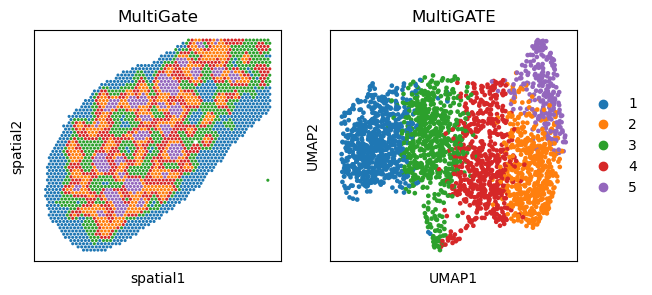

<Figure size 700x300 with 0 Axes>

In [8]:

plt.rcParams["figure.figsize"] = (7, 3) 
fig, axs = plt.subplots(1, 2)
sc.pl.embedding(adata1, basis='spatial', color='mclust',  title='MultiGate', s=size, show=False,ax=axs[0],legend_loc=None)
sc.pp.neighbors(adata1, use_rep='MultiGATE_clip_all',key_added = 'avg');
sc.tl.umap(adata1,neighbors_key = 'avg');
sc.pl.umap(adata1, color="mclust",title='MultiGATE',ax=axs[1]);

plt.tight_layout()
plt.show()